### Proxilmal Policy Optimization

This is an implementation of the following paper by <a href="https://openai.com/">OpenAI</a><br>
<b><I>Proximal Policy Optimization Algorithms</b></I> <a href="https://arxiv.org/abs/1707.06347">arxiv link</a><br><br>
Implemented by : Irfan Mohammad Al Hasib <br>
E-Mail : irfanhasib.me@gmail.com <br>
Website : <a href="https://irfanhasib0.github.io">https://irfanhasib0.github.io</a><br>
LinkedIN : <a href="https://www.linkedin.com/in/irfanhasib/">https://www.linkedin.com/in/irfanhasib/</a><br>

1. Impletated from scratch with tensorflow
2. Tested for Bipedal walker environment of OpenAI <br>



### Importing necessary libraries

In [1]:
seed=1
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['PYTHONHASHSEED']=str(seed)
import numpy as np
np.random.seed(seed)
import tensorflow as tf
tf.random.set_seed(seed)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense ,Input,concatenate ,Conv2D,Conv2DTranspose,\
MaxPooling2D,AveragePooling2D, LSTM ,Reshape, TimeDistributed,ReLU, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam,Adagrad
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
import warnings
import glob
import math
import cv2
from matplotlib import pyplot as plt
import pandas as pd
import pickle
from collections import deque
from tqdm import tqdm,trange
import gym
import imageio
from datetime import datetime
from copy import copy , deepcopy
TanH=tf.keras.layers.Activation('tanh')
Sigmoid=tf.keras.layers.Activation('sigmoid')

### Basic settings and paths

In [2]:
train_ppo_agent=True
env_name = 'BipedalWalker-v2'
exp_root_path='exps/ppo_exp_1'
if not os.path.exists(exp_root_path): os.makedirs(exp_root_path)

### Hiperparameters setting

In [3]:
params_dict={
'_actor_lr' : 0.001,
'_critic_lr' : 0.001,
'_value_coef' : 0.5,
'_entropy_coef' : 0.01,
'_gamma' : 0.99,
'_lambda' : 0.95,
'_clip_epsilon' : 0.05,
'_advantage' : 10,
'_time_steps' : 2000,
'_episodes' : 1000,
'_train_steps': 5
}
param_str='Time : '+str(datetime.now()) +'\n'+'Exp Name : ' + exp_root_path+'\n'
for key in params_dict.keys():
    param_str += str( key + ' = '+str(params_dict[key]) +'\n' )
with open(exp_root_path+'/params.txt','w') as file:
    file.write(param_str)

###  Classes definations
1. Class Actor():

        Class for creating actor Network inheriting tensorflow.keras Model class
        
        -> __init__ : Layer definations
        -> call() : Network building
2. Class Critic():
        
        -Class for creating actor Network inheriting tensorflow.keras Model class
        
        -> __init__ : Layer definations
        -> call() : Network building
        
3. Class Memory():
        
        Class for storing data samples and retriving when necessary. Each data sample to be stored consists of : state , action , mean, std, value, mask, reward
        
        -> append(data sample) appends one sample 
        -> retrive() -> data sample, retrives all the stored samples and cleares memory
4. Class Environment():
        
        
        A wrapper around OpenAI environment. 
        
        -> reset() resets the environment
        -> step() takes action and returns obserrvation, reward, terminal, info
        -> render() renders current environment image
        -> close() closes environment instance
        
4. CLass PPO_Model() : 
            
         Takes all the hiperparameters as input.
         
        -> calc_gae_values : Calculates generalized advantage estimations from values, rewards and masks
        -> calc_actor_loss : Calculates actor loss
        -> train actor : Trains actor model with calculated loss
        -> calc critic loss : Calculate critic loss
        -> train critic : Trains Critic model with calculated loss
        -> test model : Test the actor model for environment and returns test reward
        
        -> get_log_probability : calculates log of gaussian probabilities from action , mean and std
        -> get_entropy : calculates entropy from std

In [4]:
class Environment():
    def __init__(self,seed=seed):
        self.env= gym.make(env_name)
        self.env.seed(seed)
        self.n_states = self.env.observation_space.shape[0]
        self.n_actions = self.env.action_space.shape[0]
        
    def reset(self):
        return self.env.reset()
        
    def step(self,action):
        
        action = np.clip(action,-1.0,1.0)
        observation, reward, done, info = self.env.step(action)
        if reward == -100:
            reward=-2
        mask = not done
        return observation, reward, mask, info
    
    def render(self,opt):
        return self.env.render(opt)
    
    def close(self):
        self.env.close()

class Actor(Model):
    def __init__(self,n_act):
        super(Actor, self).__init__()
        self.d1 = Dense(512, activation='relu')
        self.d2 = Dense(256, activation='relu')
        self.mean = Dense(n_act)
        self.tanh  = TanH
        self.sigmoid  = Sigmoid
        self.std = Dense(n_act)

    def call(self, x):
        x = self.d1(x)
        x = self.d2(x)
        mean = self.mean(x)
        mean = self.tanh(mean)
        std = self.std(x)
        std = self.sigmoid(std)
        return mean,std+10e-10


class Critic(Model):
    def __init__(self):
        super(Critic, self).__init__()
        self.d1 = Dense(512, activation='relu')
        self.d2 = Dense(256, activation='relu')
        self.value = Dense(1)

    def call(self, x):
        x = self.d1(x)
        x = self.d2(x)
        value = self.value(x)
        return value
    
class Memory():
        def __init__(self,_len=None,n_states=None,n_actions=None):
            self._len=_len
            self.n_states=n_states
            self.n_actions=n_actions
            self.clear()

        def clear(self):
            _len=self._len
            self.curr_states = np.zeros((_len,self.n_states),dtype=np.float32)
            self.old_actions = np.zeros((_len,self.n_actions),dtype=np.float32)
            self.values = np.zeros((_len,1),dtype=np.float32)
            self.masks = np.zeros((_len,1),dtype=np.float32)
            self.rewards = np.zeros((_len,1),dtype=np.float32)
            self.old_means = np.zeros((_len,self.n_actions),dtype=np.float32)
            self.old_stds  = np.zeros((_len,self.n_actions),dtype=np.float32)
            self.i=0
            
        def append(self,state,action,mean,std,q_value,mask,reward):
            self.curr_states[self.i,:]=state
            self.old_actions[self.i,:]=action
            self.old_means[self.i,:]=mean
            self.old_stds[self.i,:]=std
            self.values[self.i,:]=q_value
            self.masks[self.i,:]=mask
            self.rewards[self.i,:]=reward
            self.i+=1
        
        def retrive(self):
            curr_states=self.curr_states.copy()
            old_actions=self.old_actions.copy()
            old_means=self.old_means.copy()
            old_stds=self.old_stds.copy()
            values=self.values.copy()
            rewards=self.rewards.copy()
            masks  = self.masks.copy()
            self.clear()
            return curr_states,old_actions,old_means,old_stds,values,rewards,masks
        
class PPO_Model():
    def __init__(self,n_actions=None,_actor_lr = 0.001, _critic_lr = 0.001,_value_coef=0.5,_entropy_coef=0.01,_gamma=0.99,
                _lambda=0.95,_clip_epsilon=0.05,_advantage= 10, _time_steps=2000,_episodes=1000,_train_steps=5):
        self._actor=Actor(n_actions)
        self._critic=Critic()

        self._actor_opt= Adam(_actor_lr)
        self._critic_opt= Adam(_critic_lr)
        self._value_coef=_value_coef
        self._entropy_coef= _entropy_coef
        self._gamma= _gamma
        self._lambda= _lambda
        self._clip_epsilon= _clip_epsilon
        self._advantage= _advantage
        self._time_steps = _time_steps
        self._episodes = _episodes
        self._train_steps = _train_steps
        
    def calc_gae_values(self,n_values, n_masks, n_rewards):
        target_qvals = []
        for i in range(len(n_rewards)-self._advantage):
            values=n_values[i:i+self._advantage+1]
            rewards=n_rewards[i:i+self._advantage]
            masks=n_masks[i:i+self._advantage]
            gae=0
            for j in range(self._advantage):
                delta = rewards[j] + self._gamma * values[j + 1] * masks[j] - values[j]
                gae +=  ((self._gamma * self._lambda)**j) * masks[j] * delta
            target_qvals.append(gae + values[0])

        adv = np.array(target_qvals) - n_values[:-self._advantage-1]
        return target_qvals, (adv - np.mean(adv)) / (np.std(adv) + 1e-10)
    

    def calc_actor_loss(self,mean,std,old_mean,old_std,old_action,advantage_raw):#, rewards, values):
        old_probs = self.get_log_probs(old_action,old_mean,old_std)
        new_probs = self.get_log_probs(old_action,mean,std)
        entropy_loss = self.get_entropy(std)
        ratio = K.exp(new_probs-old_probs)
        p1 = ratio * advantage_raw
        p2 = K.clip(ratio, min_value=1 - self._clip_epsilon, max_value=1 + self._clip_epsilon) * advantage_raw
        actor_loss = K.mean(K.minimum(p1, p2))
        total_loss =   -actor_loss - self._entropy_coef * entropy_loss 
        return total_loss

    @tf.function
    def train_actor_network(self,curr_states,old_mean,old_std,old_actions,advantage_raw):
        advantage_raw=tf.cast(advantage_raw,tf.float32)
        with tf.GradientTape() as tape:
            mean,std = self._actor(curr_states, training=True)
            act_loss = self.calc_actor_loss(mean,std,old_mean,old_std,old_actions,advantage_raw)
            gradients = tape.gradient(act_loss, self._actor.trainable_variables)
            self._actor_opt.apply_gradients(zip(gradients, self._actor.trainable_variables))
        return  act_loss

    @tf.function          
    def calc_critic_loss(self,_values,_target_rewards):
            batch_size=_values.shape[0]
            critic_loss=self._value_coef*2*tf.reduce_sum(tf.square(_target_rewards-_values))/batch_size
            return critic_loss
        
    @tf.function
    def train_critic_network(self,states,target_rewards):
        with tf.GradientTape() as tape:
            values=self._critic(states)
            values=tf.cast(values,tf.float32)
            target_rewards=tf.cast(target_rewards,tf.float32)
            critic_loss=self.calc_critic_loss(values,target_rewards)
            gradients = tape.gradient(critic_loss, self._critic.trainable_variables)
            self._critic_opt.apply_gradients(zip(gradients, self._critic.trainable_variables))
        return critic_loss
    
    @tf.function
    def get_log_probs(self,_actions,mean,std):
        _actions=tf.cast(_actions,tf.float32)
        mean=tf.cast(mean,tf.float32)
        std=tf.cast(std,tf.float32)
        _var = -0.5*((_actions-mean)/(std))**2
        _coef = 1/(std*tf.sqrt(2*np.pi)) 
        _probs = _coef*tf.cast(tf.exp(_var),tf.float32)
        log_probs = tf.math.log(_probs)
        return log_probs
    
    def get_entropy(self,std):
        entropy = 0.5 * (tf.math.log(2 * np.pi * std ** 2) + 1)
        return entropy
    
    def test_reward(self,i_seed):
        env=Environment(seed=i_seed)
        state = env.reset()
        mask = True
        total_reward = 0
        while mask:
            state_input = K.expand_dims(state, 0)
            mean,std = self._actor(state_input)
            act=np.random.normal(mean,std)[0]
            next_state, reward, mask, _ = env.step(mean[0])
            state = next_state
            total_reward += reward
        env.close()
        return total_reward


### The training loop

In [5]:
if train_ppo_agent==True:
    # Creating envronment
    env=Environment()
    n_states= env.n_states
    n_actions = env.n_actions
    state = env.reset()
    
    rewards_log=[]
    max_reward=0
    
    ppo_model=PPO_Model(n_actions=env.n_actions,**params_dict)
    ppo_memory = Memory(_len=(ppo_model._time_steps+ppo_model._advantage),n_states=n_states,n_actions=n_actions)
    
                
    for episode in range(ppo_model._episodes):
        
        state_input = None
        sum_reward=0
        sum_reward_log=0
        
        for itr in trange(ppo_model._time_steps+ppo_model._advantage):
            state_input = K.expand_dims(state, 0)
            mean,std = ppo_model._actor(state_input)
            q_value  = ppo_model._critic(state_input)
            action = np.random.normal(mean,std)[0]
            
            observation, reward, mask, info = env.step(action)
            
            
            sum_reward+=reward
            ppo_memory.append(state,action,mean,std,q_value,mask,reward)
            
            state = observation
            if not mask: # mask is invert of done / terminal
                sum_reward_log=copy(sum_reward)
                sum_reward=0
                env.reset()
        
        curr_states,old_actions,old_means,old_stds,values,rewards,masks = ppo_memory.retrive()
        state_input=K.expand_dims(state, 0)
        q_value = ppo_model._critic(state_input)
        values=np.concatenate([values,q_value],axis=0)
        
        for _ in trange(ppo_model._train_steps):
                adv = ppo_model._advantage
                target_qvals, advantages = ppo_model.calc_gae_values(values, masks, rewards)
                ppo_model.train_actor_network(curr_states[:-adv],old_means[:-adv],old_stds[:-adv],old_actions[:-adv],advantages)
                ppo_model.train_critic_network(curr_states[:-adv],target_qvals)                            

        avg_reward = np.mean([ppo_model.test_reward(i) for i in trange(5)])
        print('episode :',episode,'reward :',sum_reward_log)   
        print('total test reward=' + str(avg_reward))
        
        if avg_reward >=max_reward:
            ppo_model._actor.save_weights(exp_root_path+'/ppo_best_actor.hdf5')
            ppo_model._critic.save_weights(exp_root_path+'/ppo_best_critic'+'.hdf5')
            best_eps=episode
            max_reward = avg_reward
        rewards_log.append([sum_reward_log,avg_reward])
        env.reset()

    env.close()
    plt.plot(rewards_log)

### Training output is cleared ---

### Train and Test rewards

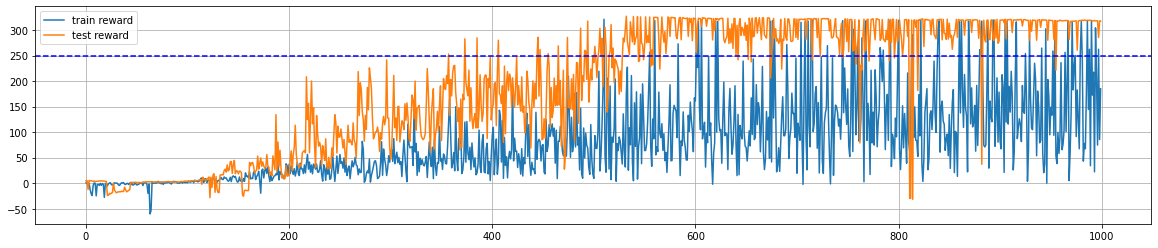

In [6]:
if train_ppo_agent==True:
    f=open(exp_root_path+'/ppo-biped-loss.pkl','wb')
    pickle.dump(rewards_log,f)
    f.close()
else: 
    f=open(exp_root_path+'/ppo-biped-loss.pkl','rb')
    rewards_log=pickle.load(f)
    f.close()
fig,axes=plt.subplots(nrows=1,ncols=1,figsize=(20,4))
axes.plot(rewards_log)
axes.legend(['train reward','test reward'])
axes.grid()
axes.axhline(y=250,color='b',linestyle='--')
fig.savefig(exp_root_path+'/bipedal-ppo.png')

### Test on Bipedal Environment

In [7]:
env = Environment()
if train_ppo_agent == False:
    ppo_model=PPO_Model(n_actions=env.n_actions,**params_dict)
_actor=ppo_model._actor
_actor(np.ones((1,env.n_states)))
_actor.load_weights(exp_root_path+'/ppo_best_actor.hdf5')

In [8]:
state=env.reset()
i=0
ter_count=0
img_save_path=exp_root_path+'/bipedal_ppo/'
if not os.path.exists(img_save_path): os.makedirs(img_save_path)
    
while True:
    action=_actor(state.reshape(1,24))
    state,rwd,mask,info=env.step(action[0][0])
    img=env.render('rgb_array')
    cv2.imwrite(img_save_path+str(i)+'.jpg',img)
    i+=1
    if mask==False:
            ter_count+=1
            state=env.reset()
    if ter_count==5:
             break
env.close()

In [9]:
fnames=[img_save_path+str(i)+'.jpg' for i in range(1000)]
with imageio.get_writer(img_save_path+'bipedal_ppo.gif', mode='I') as writer:
    for fname in tqdm(fnames):
        image = imageio.imread(fname)
        writer.append_data(image)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:24<00:00, 40.69it/s]


### Saved GIF of test results

<img src = 'exps/ppo_exp_1/bipedal_ppo/bipedal_ppo.gif'>

### Thank You